### study1_answer_and_rubric_task_train_and_eval_v0.1
- 最終更新: 2023/8/4, 19:48→保存するディレクトリ間違っていたので、帰ったらもう一回まわす(2023/8/4, 12:59)→回した（2023/8/6, 14:33）

- 研究1: 回答+基準表/課題含む（案1）

- 「目的案1. 日本語版SSTの自動採点モデルの有効性調査」
  - 意図: モデルを<u>SSTのみ</u>に適用する状況での精度評価
  - 方法: 予備調査の採点結果で学習・評価（研究1）→研究1のモデルで本調査aの項目の一部を評価(研究2)
    - 20項目全ての採点基準表/過去データをもとに分析
    - 例: テストデータ/訓練データともに「飛行機-鳥」を含む（同一の回答は含まれないが）
    
  - 示唆: 日本語版SSTで学習したモデルがどれくらい日本語版SSTの自動採点において有効かを定量評価できる。

#### Google Driveのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 環境構築

aptやらpipやらの下準備
- 参考: https://qiita.com/karaage0703/items/30485c2ba1c396760982

In [2]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7
!pip install fugashi ipadic unidic-lite
!pip install scikit-learn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
Suggested packages:
  apt-xapian-index aptitude-doc-en | aptitude-doc debtags tasksel
  libcwidget-dev xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 3,838 kB of archives.
After this operation, 17.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aptitude-common all 0.8.13-3ubuntu1 [1,719 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsigc++-2.0-0v5 amd64 2.10.4-2ubuntu3 [12.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcwidget4 amd64 0.5.18-5build1 [306 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libxapian30 amd64

In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.6 MB/s eta 0:00:00


In [4]:
#transformersの準備
!pip install transformers[torch] neologdn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 26.4 MB/s eta 0:00:00
  Created wheel for neologdn: filename=neologdn-0.5.2-cp310-cp310-linux_x86_64.whl size=219144 sha256=9c1d4615de137f8634ed68e7e5c9179197d825f0f3235defc36efd4bd5a9ecf3
  Stored in directory: /root/.cache/pip/wheels/bd/87/af/2a36d74f666a8428943b70d71c5e9dd740435bf671f210672c
Successfully built neologdn


In [5]:
pip install accelerate -U

In [6]:
#GPUの認識状況の確認
!nvidia-smi

Sun Aug  6 04:56:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### 以下はコード

##### データの準備
- v0.2までは`data_basic`を使っていた（train/test splitのみ実施）


In [7]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import tqdm

In [8]:
import torch
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from transformers import AdamW

In [9]:
#乱数のseedを全固定する
#ref: https://qiita.com/ku_a_i/items/bac3befedbadab45774f
import random
import os
RANDOM_STATE = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(RANDOM_STATE)

In [10]:
#データの読み込み
data_rubric = pd.read_excel('/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/data/CreateSST_PreExp_SST_20230103_1258_ScoringKey_v5.1.xlsx', sheet_name=0, index_col=None)
data_rubric = data_rubric.rename(columns={"point": "labels"})
data_rubric.head()

,word_pair,word1,word2,scoring_key,labels
0,鳥-飛行機,鳥,飛行機,飛ぶ,2
1,鳥-飛行機,鳥,飛行機,空を飛ぶ,2
2,鳥-飛行機,鳥,飛行機,空を飛ぶことができる,2
3,鳥-飛行機,鳥,飛行機,飛ぶことができる,2
4,鳥-飛行機,鳥,飛行機,空中を移動する,2


In [11]:
#以下、data_rubricの整形

#ネガティブサンプルの作成
#study1_rubric_task_train_and_evalと同じ方法

#新しいデータフレームを作る
data_rubric_with_ns = pd.DataFrame(columns=data_rubric.columns)

#正例の件数を数える
data_rubric_ps_count = data_rubric.groupby("word_pair").size()

#word_pairを回す
for cur_word_pair in data_rubric.word_pair.unique():
  #data_rubricの現在のword_pairをそのまま新しいデータフレームにコピペする
  sub_word_pair = data_rubric[data_rubric["word_pair"] == cur_word_pair]
  data_rubric_with_ns = pd.concat([data_rubric_with_ns, sub_word_pair])

  #data_rburicから現在のpairを除いたsubsetを作る
  sub_without_word_pair = data_rubric[data_rubric["word_pair"] != cur_word_pair]

  #subsetからランダムにword_pair件数の半分をサンプルし、labels = 0とする
  cur_negative_samples = sub_without_word_pair.sample(n=data_rubric_ps_count[cur_word_pair] // 2)
  cur_negative_samples["word_pair"] = cur_word_pair
  cur_negative_samples["word1"] = cur_word_pair.split("-")[0]
  cur_negative_samples["word2"] = cur_word_pair.split("-")[1]
  cur_negative_samples["labels"] = 0

  #新しいデータフレームに上記サンプル結果をコピペする
  data_rubric_with_ns = pd.concat([data_rubric_with_ns, cur_negative_samples])

In [12]:
data_rubric_with_ns_reset_index = data_rubric_with_ns.reset_index()
data_rubric_with_ns_reset_index

,index,word_pair,word1,word2,scoring_key,labels
0,0,鳥-飛行機,鳥,飛行機,飛ぶ,2
1,1,鳥-飛行機,鳥,飛行機,空を飛ぶ,2
2,2,鳥-飛行機,鳥,飛行機,空を飛ぶことができる,2
3,3,鳥-飛行機,鳥,飛行機,飛ぶことができる,2
4,4,鳥-飛行機,鳥,飛行機,空中を移動する,2
...,...,...,...,...,...,...
611,236,美術館-墓,美術館,墓,人々の受け皿になる,0
612,361,美術館-墓,美術館,墓,複数層からなる,0
613,260,美術館-墓,美術館,墓,土台がしっかりしている,0
614,258,美術館-墓,美術館,墓,強固な基礎がある,0


In [13]:
#data_rubric_with_ns_reset_indexを結合用に調整する
data_rubric_basic = data_rubric_with_ns_reset_index.copy()
data_rubric_basic = data_rubric_basic.rename(columns={"scoring_key": "answer"})#answerと名前を揃える
data_rubric_basic = data_rubric_basic.drop(columns=["index", "word_pair"])
data_rubric_basic

,word1,word2,answer,labels
0,鳥,飛行機,飛ぶ,2
1,鳥,飛行機,空を飛ぶ,2
2,鳥,飛行機,空を飛ぶことができる,2
3,鳥,飛行機,飛ぶことができる,2
4,鳥,飛行機,空中を移動する,2
...,...,...,...,...
611,美術館,墓,人々の受け皿になる,0
612,美術館,墓,複数層からなる,0
613,美術館,墓,土台がしっかりしている,0
614,美術館,墓,強固な基礎がある,0


In [14]:
#なぜかword1/word2にスペースが混ざっているケースがあったので削除する
def remove_dumb_spaces(string):
  return string.rstrip().lstrip()

data_rubric_basic["word1"] = data_rubric_basic["word1"].map(remove_dumb_spaces)
data_rubric_basic["word2"] = data_rubric_basic["word2"].map(remove_dumb_spaces)

### 訓練データとテストデータの分割→回答+採点基準表モデルでは不要
- 採点基準表: 上記の`data_rubric_basic`全件
- 回答: `/(home)/result/study1/study1_answer_task_train_and_eval/`のFold0~Fold4の`data_train.csv`
- 上記を結合して使う

In [15]:
base_data_answer_train_dir = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study1/study1_answer_task_train_and_eval/"
tmp_data_answer_train_dir = base_data_answer_train_dir + "Fold0/data_train.csv"
tmp_data_answer_fold = pd.read_csv(tmp_data_answer_train_dir)
tmp_data_answer_fold

,level_0,index,word1,word2,answer,labels,text,kFold
0,0,0,鳥,飛行機,とぶもの,2,鳥 [SEP] 飛行機[SEP]とぶもの,1
1,1,1,剣,拳銃,攻撃するもの,1,剣 [SEP] 拳銃[SEP]攻撃するもの,2
2,3,3,太陽,電球,光る,2,太陽 [SEP] 電球[SEP]光る,4
3,6,6,道,川,筋になっている,1,道 [SEP] 川[SEP]筋になっている,4
4,7,7,愛,薬物,夢中になる,2,愛 [SEP] 薬物[SEP]夢中になる,4
...,...,...,...,...,...,...,...,...
970,1210,1903,愛,薬物,欲する,1,愛 [SEP] 薬物[SEP]欲する,3
971,1212,1908,時間,川,永遠,1,時間 [SEP] 川[SEP]永遠,1
972,1214,1910,酒場,教会,のめり込む,1,酒場 [SEP] 教会[SEP]のめり込む,4
973,1216,1913,記憶,牢獄,覚える,0,記憶 [SEP] 牢獄[SEP]覚える,3


In [16]:
#整形する
tmp_data_answer_fold_basic = tmp_data_answer_fold.copy()
tmp_data_answer_fold_basic = tmp_data_answer_fold_basic.drop(columns=["level_0"])
tmp_data_answer_fold_basic = tmp_data_answer_fold_basic.reset_index()
tmp_data_answer_fold_basic = tmp_data_answer_fold_basic.drop(columns=["level_0", "index", "text", "kFold"])
tmp_data_answer_fold_basic

,word1,word2,answer,labels
0,鳥,飛行機,とぶもの,2
1,剣,拳銃,攻撃するもの,1
2,太陽,電球,光る,2
3,道,川,筋になっている,1
4,愛,薬物,夢中になる,2
...,...,...,...,...
970,愛,薬物,欲する,1
971,時間,川,永遠,1
972,酒場,教会,のめり込む,1
973,記憶,牢獄,覚える,0


In [17]:
#結合する
tmp_data_answer_fold_and_rubric_basic = pd.concat([tmp_data_answer_fold_basic, data_rubric_basic])
tmp_data_answer_fold_and_rubric_basic = tmp_data_answer_fold_and_rubric_basic.reset_index()
tmp_data_answer_fold_and_rubric_basic = tmp_data_answer_fold_and_rubric_basic.drop(columns=["index"])
tmp_data_answer_fold_and_rubric_basic["text"] = tmp_data_answer_fold_and_rubric_basic["word1"] + "[SEP]" + tmp_data_answer_fold_and_rubric_basic["word2"] + "[SEP]" + tmp_data_answer_fold_and_rubric_basic["answer"]
tmp_data_answer_fold_and_rubric_basic

,word1,word2,answer,labels,text
0,鳥,飛行機,とぶもの,2,鳥 [SEP] 飛行機[SEP]とぶもの
1,剣,拳銃,攻撃するもの,1,剣 [SEP] 拳銃[SEP]攻撃するもの
2,太陽,電球,光る,2,太陽 [SEP] 電球[SEP]光る
3,道,川,筋になっている,1,道 [SEP] 川[SEP]筋になっている
4,愛,薬物,夢中になる,2,愛 [SEP] 薬物[SEP]夢中になる
...,...,...,...,...,...
1586,美術館,墓,人々の受け皿になる,0,美術館[SEP]墓[SEP]人々の受け皿になる
1587,美術館,墓,複数層からなる,0,美術館[SEP]墓[SEP]複数層からなる
1588,美術館,墓,土台がしっかりしている,0,美術館[SEP]墓[SEP]土台がしっかりしている
1589,美術館,墓,強固な基礎がある,0,美術館[SEP]墓[SEP]強固な基礎がある


In [18]:
tmp_data_answer_fold_and_rubric_basic.value_counts(subset=["labels"])

labels
1         728
2         593
0         270
dtype: int64

#### data_basicをdatasetに変換する

##### 準備に必要な関数群
- 以下は, v0.3からのkfoldする場合にdatasetに変換する方法->この部分はtrainerとかと一緒にfor文で回した方が良いか
- create_dataset: データセットを作成する関数
  - `data_basic_unique_with_folds`から学習データと評価データを分けて用意する
  - ref: https://www.philschmid.de/k-fold-as-cross-validation-with-a-bert-text-classification-example
- compute_metrics：評価指標の計算に用いるやつ
- CustomTrainer: 重みをそれぞれ変えるtrainerの設定に必要なやつ
- load_config: wiehgt_allとlogging_stepsを求めるのに必要なやつ

In [19]:
#cudaを使う準備
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [20]:
from datasets import Dataset
def create_dataset(data_all):
  """
  dataset（pandasのデータフレーム）をtorchで使えるデータセットにする
  """

  def tokenize_basic(batch):
      return tokenizer(batch["text"], padding=True, truncation=True)

  #datasetをtrainとtestに分ける
  #ref: https://www.ai-shift.co.jp/techblog/2138
  data_all = data_all.reset_index()
  dataset_all = Dataset.from_pandas(data_all)

  #datasetの雛形を元に[CLS]【単語1】[SEP]【単語2】[SEP]【参加者の回答】[SEP]とを用意
  dataset_all_encoded = dataset_all.map(tokenize_basic, batched=True, batch_size=None)

  return dataset_all_encoded, data_all


# メトリクスの定義
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#Trainerの重みを変えるやつ
#imbalanced dataのlossの定義
#ref: https://huggingface.co/docs/transformers/main/main_classes/trainer
#ref: https://dev.classmethod.jp/articles/huggingface-usage-custom-loss-func/
from transformers import TrainingArguments
from transformers import Trainer
from transformers import EarlyStoppingCallback
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        #2023/4/6: debug
        # print("compute_loss: labels, logits", labels, logits)
        # print("compute_loss: outputs: ", outputs)

        # compute custom loss (suppose one has 3 labels with different weights)
        # 訓練データの正例の逆数で重み付け
        loss_fct = nn.CrossEntropyLoss(weight=cur_config["weight_all"])
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        #print()
        # print("loss_fct: ", loss_fct)
        # print("loss: ", loss)

        return (loss, outputs) if return_outputs else loss

def load_bert_model_and_tokenizer():
  """
  BERTのモデルとトークナイザを呼び出す関数
  ※都度初期化して呼び出したいため、ここで呼ぶ
  """

  model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
  model = model.to(device)
  tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

  return model, tokenizer


class load_config:
  """
  cur_fold_idxを引数として、そのfoldにおけるlogging_stepsとweight_allを受け取る
  """
  #初期化
  def __init__(self, cur_fold_idx):
    self.cur_fold_idx = cur_fold_idx
    self.config = dict()

  def create_logging_steps(self):
    self.config["logging_steps"] = len(cur_data_answer_fold_and_rubric_basic) // BATCH_SIZE

  def create_weight_all(self):
    """
    weight_allを計算する
    ref: https://dev.classmethod.jp/articles/huggingface-usage-custom-loss-func/
    ref_conc: weight_all = torch.tensor([len(data_basic_unique_train)/75, len(data_basic_unique_train)/528, len(data_basic_unique_train)/494]).clone().to(device, torch.float32)
    """
    self.config["weight_all"] = torch.tensor([len(cur_data_answer_fold_and_rubric_basic) /len(cur_data_answer_fold_and_rubric_basic.query("labels== 0")),
                                            len(cur_data_answer_fold_and_rubric_basic) /len(cur_data_answer_fold_and_rubric_basic.query("labels== 1")),
                                            len(cur_data_answer_fold_and_rubric_basic) /len(cur_data_answer_fold_and_rubric_basic.query("labels== 2"))]).clone().to(device, torch.float32)

  def return_config(self):
    self.create_logging_steps()
    self.create_weight_all()
    return self.config

#結果の評価
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
def plot_confusion_matrix(y_preds, y_true, output_dir):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.savefig(output_dir+"confusion_matrix.png")
    plt.show()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Map:   0%|          | 0/1591 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.061500,0.944845,0.471402,0.402880
2,0.910800,0.705697,0.745443,0.743898
3,0.761200,0.534069,0.768070,0.773573
4,0.626300,0.396598,0.868008,0.866479
5,0.502500,0.301958,0.886864,0.890872
6,0.402900,0.204613,0.936518,0.937964
7,0.332800,0.145182,0.959774,0.960179
8,0.254600,0.109089,0.967945,0.968081
9,0.205100,0.090372,0.973602,0.973810
10,0.192300,0.079532,0.979258,0.979358


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_answer_and_rubric_task_train_and_eval/Fold0/checkpoint-500


Map:   0%|          | 0/244 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           2       0.33      0.44      0.38        16
           1       0.86      0.79      0.82       118
           0       0.86      0.90      0.88       110

    accuracy                           0.82       244
   macro avg       0.69      0.71      0.69       244
weighted avg       0.83      0.82      0.82       244



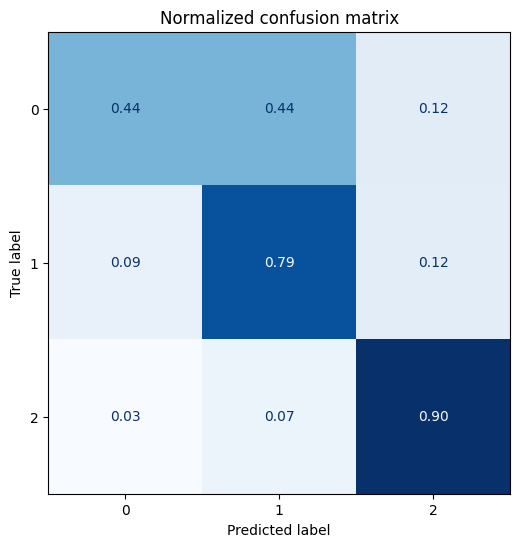

Map:   0%|          | 0/1591 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.069500,0.915456,0.571339,0.572700
2,0.925100,0.693145,0.736644,0.740140
3,0.766200,0.496657,0.830924,0.833837
4,0.609300,0.344905,0.898806,0.898842
5,0.461800,0.245773,0.916405,0.918095
6,0.380600,0.153369,0.959774,0.960094
7,0.298500,0.113121,0.971716,0.971915
8,0.239500,0.081345,0.980515,0.980604
9,0.198700,0.068477,0.981772,0.981809
10,0.179300,0.062106,0.987429,0.987438


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_answer_and_rubric_task_train_and_eval/Fold1/checkpoint-500


Map:   0%|          | 0/244 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           2       0.38      0.35      0.36        17
           1       0.88      0.85      0.86       117
           0       0.86      0.91      0.88       110

    accuracy                           0.84       244
   macro avg       0.71      0.70      0.70       244
weighted avg       0.84      0.84      0.84       244



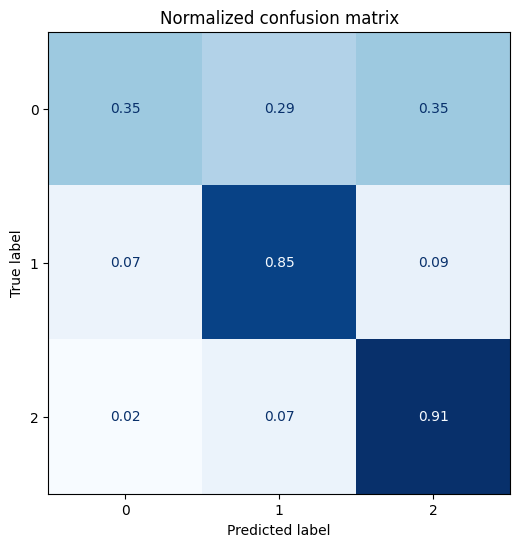

Map:   0%|          | 0/1591 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.071200,0.942554,0.569453,0.560921
2,0.935500,0.708214,0.737901,0.744042
3,0.758900,0.521180,0.796983,0.796359
4,0.582900,0.326143,0.905091,0.905478
5,0.448700,0.223384,0.921433,0.923258
6,0.345600,0.140693,0.967316,0.967326
7,0.272500,0.104252,0.967945,0.968205
8,0.225600,0.072596,0.984915,0.984911
9,0.172000,0.060263,0.984915,0.984940
10,0.162900,0.054540,0.986801,0.986819


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_answer_and_rubric_task_train_and_eval/Fold2/checkpoint-500


Map:   0%|          | 0/244 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           1       0.25      0.18      0.21        17
           0       0.86      0.81      0.84       117
           2       0.84      0.94      0.89       110

    accuracy                           0.82       244
   macro avg       0.65      0.64      0.64       244
weighted avg       0.81      0.82      0.82       244



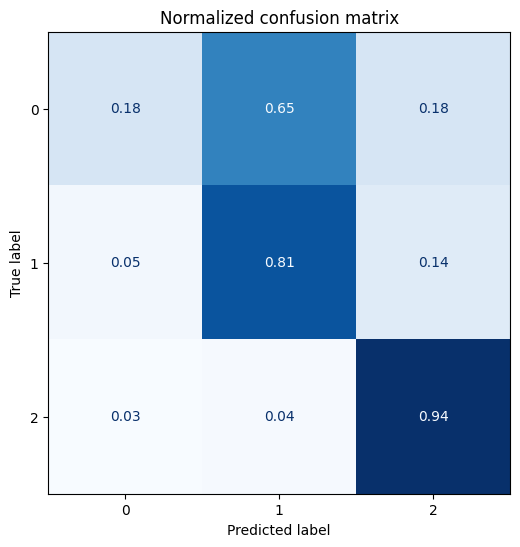

Map:   0%|          | 0/1591 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.083100,0.971379,0.606537,0.596671
2,0.954400,0.734933,0.702074,0.710243
3,0.779200,0.509607,0.833438,0.835662
4,0.620300,0.352341,0.901948,0.901125
5,0.468800,0.233384,0.945317,0.945178
6,0.362500,0.141500,0.964173,0.964389
7,0.269900,0.105041,0.972344,0.972386
8,0.215000,0.073223,0.981144,0.981160
9,0.170500,0.059073,0.981772,0.981809
10,0.148200,0.052070,0.986172,0.986192


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_answer_and_rubric_task_train_and_eval/Fold3/checkpoint-500


Map:   0%|          | 0/244 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           2       0.50      0.35      0.41        17
           1       0.88      0.85      0.87       117
           0       0.85      0.91      0.88       110

    accuracy                           0.84       244
   macro avg       0.74      0.71      0.72       244
weighted avg       0.84      0.84      0.84       244



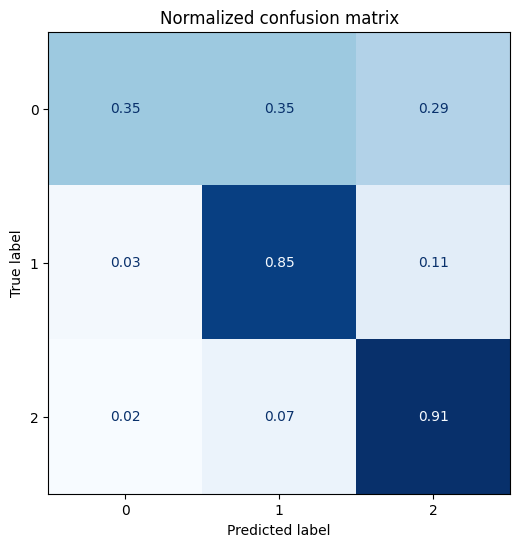

Map:   0%|          | 0/1592 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.074100,0.952197,0.528266,0.549170
2,0.926400,0.718876,0.696608,0.701401
3,0.759100,0.488931,0.844221,0.844989
4,0.595300,0.373444,0.895101,0.893641
5,0.489600,0.255025,0.910176,0.913590
6,0.351500,0.157427,0.957286,0.957688
7,0.303900,0.112321,0.970477,0.970643
8,0.238500,0.084286,0.980528,0.980598
9,0.190200,0.069947,0.982412,0.982423
10,0.171800,0.062144,0.983668,0.983688


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_answer_and_rubric_task_train_and_eval/Fold4/checkpoint-500


Map:   0%|          | 0/243 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           2       0.67      0.38      0.48        16
           1       0.82      0.82      0.82       118
           0       0.84      0.89      0.87       109

    accuracy                           0.82       243
   macro avg       0.78      0.70      0.72       243
weighted avg       0.82      0.82      0.82       243



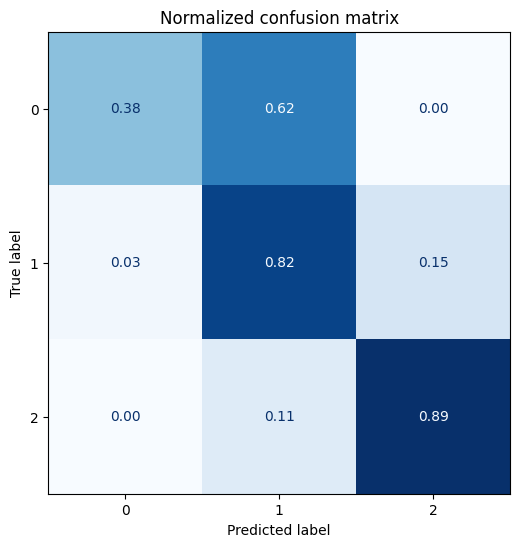

In [21]:
MODEL_OUTPUT_DIR = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_answer_and_rubric_task_train_and_eval"
MODEL_NAME = "cl-tohoku/bert-base-japanese"
BATCH_SIZE = 32

base_data_answer_train_dir = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study1/study1_answer_task_train_and_eval/"
RESULT_OUTPUT_DIR_BASE = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study1/study1_answer_and_rubric_task_train_and_eval/"

#評価データ周り
BASE_EVAL_DATA_DIR = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study1/study1_answer_task_train_and_eval/"
BASE_EVAL_RESULT_DIR = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study1/study1_answer_and_rubric_task_train_and_eval/"

NUM_FOLDS = 5

#現在のfoldを管理する
for CUR_FOLD_IDX in range(NUM_FOLDS):
  #モデルとトークナイザの初期化
  model, tokenizer = load_bert_model_and_tokenizer()

  #answerデータの用意(rubricは使いまわせる)
  cur_data_answer_train_dir = base_data_answer_train_dir + "Fold" + str(CUR_FOLD_IDX) + "/data_train.csv"
  cur_data_answer_fold = pd.read_csv(cur_data_answer_train_dir)

  #answerデータの整形とrubricとの結合
  cur_data_answer_fold_basic = cur_data_answer_fold.copy()
  cur_data_answer_fold_basic = cur_data_answer_fold_basic.drop(columns=["level_0"])
  cur_data_answer_fold_basic = cur_data_answer_fold_basic.reset_index()
  cur_data_answer_fold_basic = cur_data_answer_fold_basic.drop(columns=["level_0", "index", "text", "kFold"])

  cur_data_answer_fold_and_rubric_basic = pd.concat([cur_data_answer_fold_basic, data_rubric_basic])
  cur_data_answer_fold_and_rubric_basic = cur_data_answer_fold_and_rubric_basic.reset_index()
  cur_data_answer_fold_and_rubric_basic = cur_data_answer_fold_and_rubric_basic.drop(columns=["index"])
  cur_data_answer_fold_and_rubric_basic["text"] = cur_data_answer_fold_and_rubric_basic["word1"] + "[SEP]" + cur_data_answer_fold_and_rubric_basic["word2"] + "[SEP]" + cur_data_answer_fold_and_rubric_basic["answer"]


  #config関数から呼び出し
  cur_lc = load_config(CUR_FOLD_IDX)
  cur_config = cur_lc.return_config()

  #データセットの用意
  dataset_all_encoded, data_all = create_dataset(cur_data_answer_fold_and_rubric_basic)

  #Trainerのconfig周り
  #TrainingArgumentsの準備
  #ref: https://dev.classmethod.jp/articles/huggingface-usage-early-stopping/
  #ref: https://stackoverflow.com/questions/62525680/save-only-best-weights-with-huggingface-transformers
  training_args = TrainingArguments(
      output_dir=MODEL_OUTPUT_DIR + "/Fold" + str(CUR_FOLD_IDX) + "/",
      num_train_epochs=10,
      learning_rate=2e-5,
      per_device_train_batch_size=BATCH_SIZE,
      per_device_eval_batch_size=BATCH_SIZE,
      weight_decay=0.01,
      save_strategy="epoch",#4/4まで; noにして, どうなるかを確認する->load_best_model_at_endと重複するからnoはダメらしい
      evaluation_strategy="epoch",
      disable_tqdm=False,
      logging_steps=cur_config["logging_steps"],
      push_to_hub=False,
      log_level="error",
      label_names=['labels'],
      load_best_model_at_end=True,
      save_total_limit=1,
  )

  # Trainerの定義
  trainer = CustomTrainer(
      model=model,
      args=training_args,
      compute_metrics=compute_metrics,
      train_dataset=dataset_all_encoded,
      eval_dataset=dataset_all_encoded,
      tokenizer=tokenizer,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
  )

  # トレーニング実行
  trainer.train()

  #trainerのbestモデルの場所を書く
  print("best model: ", trainer.state.best_model_checkpoint)

  #モデルの保存を明示的に書く
  trainer.save_model()

  #以下、モデルの評価

  #評価データの読み込み
  cur_test_data_dir = BASE_EVAL_DATA_DIR + "Fold" + str(CUR_FOLD_IDX) + "/data_test.csv"
  cur_test_data = pd.read_csv(cur_test_data_dir)
  cur_test_data = cur_test_data.drop(columns=["level_0"])

  #データセットの準備
  cur_test_dataset, cur_test_data = create_dataset(cur_test_data)

  #データの評価
  cur_preds_output = trainer.predict(cur_test_dataset)

  #評価結果の保存
  cur_test_data['predict'] = cur_preds_output.predictions.argmax(axis=1).tolist()
  cur_categories = cur_test_data['labels'].unique().tolist()
  cur_categories = list(map(str, cur_categories))
  y_preds = np.argmax(cur_preds_output.predictions, axis=1)
  y_valid = np.array(cur_test_data['labels'])

  classification_report_txt = classification_report(y_valid, y_preds, target_names=cur_categories)
  print(classification_report_txt)

  #評価結果を保存するためのディレクトリの作成
  result_output_dir = BASE_EVAL_RESULT_DIR + "Fold" + str(CUR_FOLD_IDX) + "/"
  if not os.path.exists(result_output_dir):
    os.makedirs(result_output_dir)

  #confusion_matrixの表示と保存
  plot_confusion_matrix(cur_test_data["predict"], cur_test_data["labels"], result_output_dir)

  #評価結果の保存
  with open(result_output_dir + "classification_report.txt", "w") as output_file:
    output_file.write(classification_report_txt)

  #評価データの保存
  cur_test_data.to_csv(result_output_dir+"data_test.csv", index=False)
  cur_data_answer_fold_and_rubric_basic.to_csv(result_output_dir+"data_train.csv", index=False)

  #全て初期化する
  #->ここはデータ管理の都合うまくいかないので、コメントアウトして残す(4/3)
  # del dataset_train_encoded, dataset_test_encoded, training_args, trainer, cur_lc, cur_config, model